# Data Preprocessing
- The Missing values are for sensor and it makes sense to fill them with zero,since filling the missing values with an acutal value might cause misleading.
- There are 6000 rows and 10 columns for each of the csv files within train and test folders. This amount of data needs reduction. I have performed PCA on the transposed version of the csv files. This process will change the 6000 x 10 csv file to 10 x 10 csv file.
- The PCA model is fitted on the first csv file of the train directory to keep the dimension reduction consistent on all the logs.

In [1]:
import numpy as np
import pandas as pd 

KAGGLE = False
base_path = '/kaggle/input/' if KAGGLE else './'

# Training data
train = pd.read_csv(f'{base_path}predict-volcanic-eruptions-ingv-oe/train.csv')
sample_submission = pd.read_csv(f'{base_path}predict-volcanic-eruptions-ingv-oe/sample_submission.csv')

# Getting the ids
train_ids = train['segment_id']
test_ids = sample_submission['segment_id']

# Value to be predicted
y = train['time_to_eruption']


# Measures of Central Tendency for raw data
X = np.load(f'{base_path}volcano-pca/train.npy')
X_test = np.load(f'{base_path}volcano-pca/test.npy')

# Measures of Central Tendency for rolling data
X_rolling = np.load(f'{base_path}volcano-pca/rolling_train.npy')
X_rolling_test = np.load(f'{base_path}volcano-pca/rolling_test.npy')

In [30]:
# Importing the needed utilities for NN
import tensorflow as tf
from tensorflow.keras import Model, Input, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Dense, InputLayer, Concatenate, Add, SeparableConv2D, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import MeanAbsoluteError as MAE

# Data Preprocessing/validation utilities
from sklearn.model_selection import KFold

# Importing the plotting utilities
from matplotlib import pyplot as plt

In [39]:
y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
MAE()(y_true, y_pred).numpy()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

# Modeling
They two possible input data for this competition, image-shaped input and tabularized version of the same image:
1. Image-shaped: The input is the measures of central tendency (mean, std, etc.) of each signal which is 10x16 dataframe for each id. These measures have been calculated on raw data and the rolling data. 
2. Tabular: The Tabular format is the reshaped version of the image format with omitted columns (This is not good for Neural network).

## CNN
CNNs could be used to find patterns between the measures of central tendencies:
- By tweaking stride values we can find patterns between signals (vertical) and measures (horizontal).
- Multilpe parallel CNNs can help to generalize the graph (widening).
- Consequtive CNNs + Fully connected layers can be used to depean the Network.

In [24]:
# The Global weight initializer
WInit = TruncatedNormal(0, 1, 111)

def concat_inputs(Inp1, Inp2): 
    """
        Concatenates the raw measures with rolling measures
        
        input:
            Inp1: input1
            Inp2: input2
        return:
            Concatenated version of the two inputs
    """
    return Concatenate(axis=2)([In1, In2])
    
def fc(Inp, unit=100, n=3, activation='relu'):
    """
        Fully Connected layer used on the flattened data
        
        input:
            Inp: Input data
            unit: Number of units
            n: Number of hidden layers
            activation: activation function used in layers
        
        return:
            returning the tensor after processed by the fully connected layer
    """
    Inp = Flatten()(Inp)
    out = BatchNormalization()(Dense(unit, activation=activation ,kernel_initializer=WInit)(Inp))
    for i in range(0, n-1): out = Dense(unit, activation=activation ,kernel_initializer=WInit)(out)
        
    out = BatchNormalization()(out)
    out = Dense(1, kernel_initializer=TruncatedNormal(2, 1e-1, 11231))(out)
        
    return out

# Sub-model/layers
Each of them has 3 parts:
1. Convulotional
2. Fully Connected
3. Prediction

In [25]:
def resnet_module(inp, unit=32, stride1=(3,3), stride2=(5,5), stride3=(3,3), mid_activation=None, padding='same', bn=True, std=1e-2, seed=123):
    
    l1 = SeparableConv2D(filters=unit, 
                         kernel_size=stride1, 
                         kernel_initializer=TruncatedNormal(0, std, seed), 
                         padding=padding
                        )(inp)
    
    l2 = SeparableConv2D(filters=unit, 
                         kernel_size=stride2, 
                         kernel_initializer=TruncatedNormal(0, std*1.1, seed),
                         activation=mid_activation,
                         padding='same'
                        )(l1)
    
    l3 = SeparableConv2D(filters=unit, 
                         kernel_size=stride3, 
                         kernel_initializer=TruncatedNormal(0, std*5, seed), 
                         padding=padding
                        )(l2)
    
    la = Add()([l1, l3])
    
    if bn: return BatchNormalization()(la)
    
    return la
    

def mres(inp):
    
    # First three moduls: 10 x 16
    b1 = resnet_module(inp, stride1=(1,3), stride2=(5,5), stride3=(3,1), bn=False, std=1)
    b1 = resnet_module(b1, stride1=(3,1), stride2=(3,3), stride3=(1,3), mid_activation='relu',bn=True, std=1.5)
    b1 = resnet_module(b1, stride1=(3,3), stride2=(3,3), stride3=(3,3), mid_activation='softmax',bn=True, std=1)
    
    # Second three moduls: 10 x 16
    b2 = resnet_module(b1, unit=64, stride1=(4,4), stride2=(7,7), stride3=(4,4), mid_activation='softmax', bn=False, std=1e-2)
    b2 = resnet_module(b2, unit=64, stride1=(6,1), stride2=(3,3), stride3=(1,6),bn=False, std=1.5e-3)
    b2 = resnet_module(b2, unit=64, stride1=(4,4), stride2=(3,3), stride3=(4,4), mid_activation='softmax',bn=False, std=3e-1)
    
    p = fc(b2, unit=100, n=5, activation=None)
    
    return p

In [27]:
# Input
In1 = Input(shape=(10,16,1))



model = Model(inputs=[In1], outputs=[mres(In1)])

In [26]:
model.count_params() / 1e6

1.121644

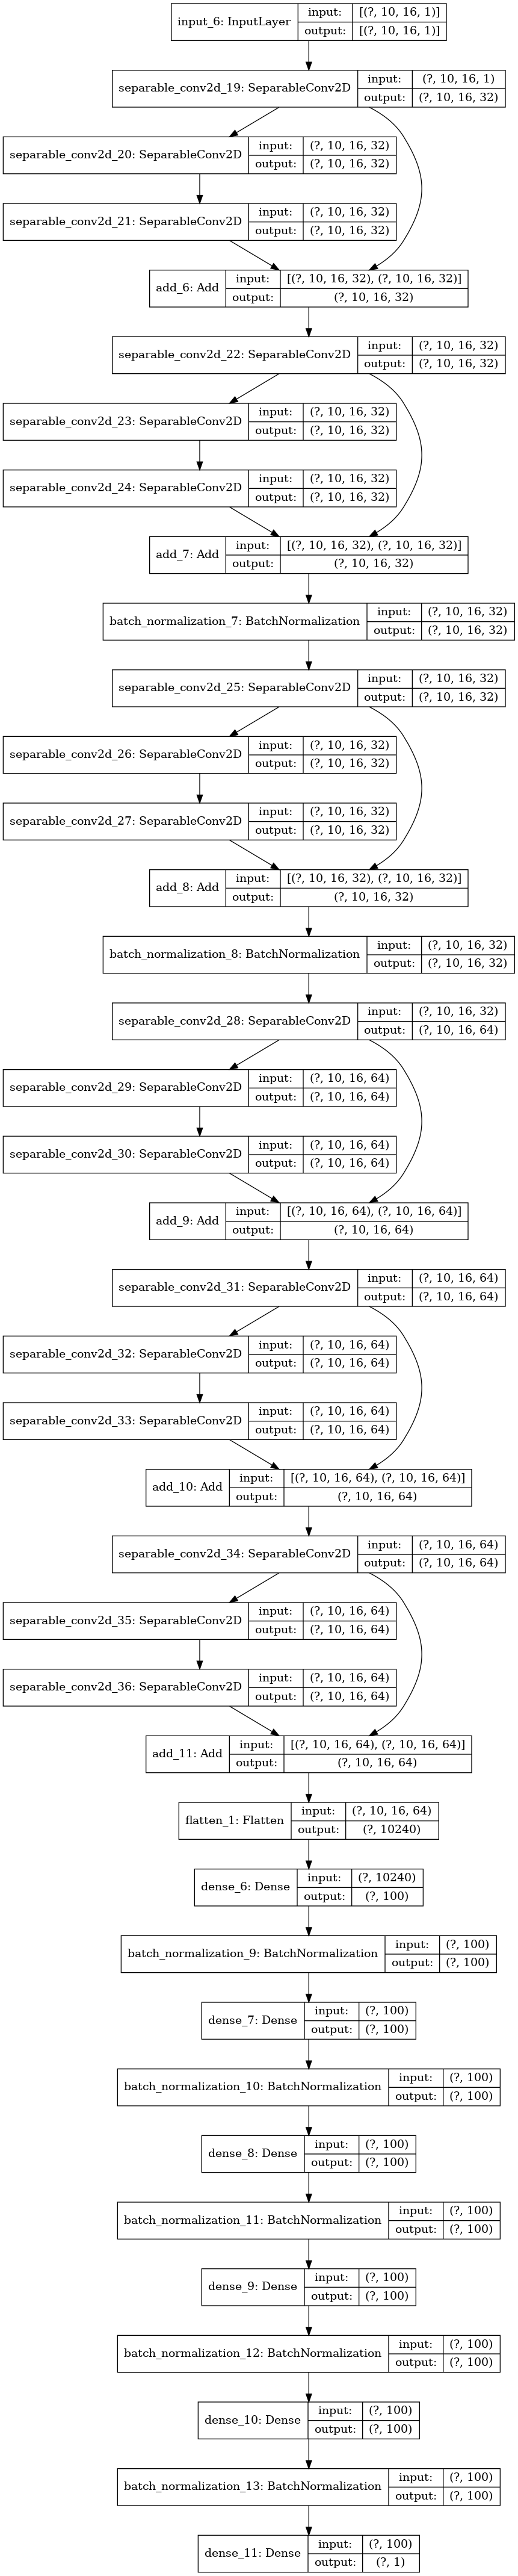

In [21]:
plot_model(model, show_layer_names=1, show_shapes=1)

In [46]:
MAE()(y_true, y_pred) / 1e6

<tf.Tensor: shape=(), dtype=float32, numpy=5e-07>

In [47]:
def custom_mse(y_true, y_pred):
    return MAE()(y_true, y_pred) / 1e6

model.compile(optimizer=Adam(0.0015), loss=custom_mse,)

hist = model.fit([X], y, epochs= 5, batch_size=128,
                 callbacks=[ReduceLROnPlateau(monitor='loss', factor=0.9, patience=10, verbose=1, min_lr=0)],
                  verbose=True,
#                   validation_split=0.33,
                  shuffle=True) 

Epoch 1/5
35/35 [==============================] - 17s 472ms/step - loss: 22.8489
Epoch 2/5
35/35 [==============================] - 17s 473ms/step - loss: 22.8489
Epoch 3/5
35/35 [==============================] - 17s 474ms/step - loss: 22.8489
Epoch 4/5
35/35 [==============================] - 17s 476ms/step - loss: 22.8489
Epoch 5/5
35/35 [==============================] - 17s 472ms/step - loss: 22.8489


In [49]:
hist.history['loss'].plot(figsize=(10,10),
                       rot=0, 
                       lw=1, 
                       colormap='jet',
                      )
plt.legend(fontsize=10)
plt.show()

AttributeError: 'list' object has no attribute 'plot'